 # <center>Hyderbad Biryani Restaurants</center>        

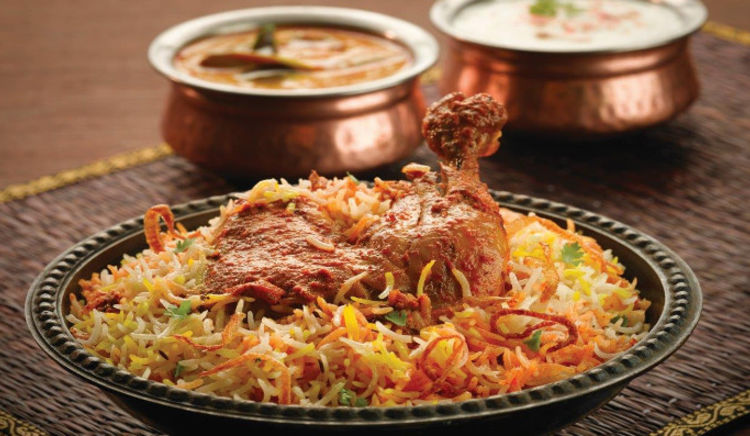

Hyderabad's biryani is world famous. It is a dish which one wouldn't want to miss when visting Hyderabd. While there are many varities of biryanis out there, the Hyderabadi Biryani stand out among all those biryanis. It is delicacy which is enjoyed by everyone irrespective of social class or religion. 

## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#result">Result and Description</a></li>    
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this notebook we will explore the briyani venues in Hyderabad. When visting any city one will definitely want to explore the local cuisine. We will be using the help of Foursqaure API and Zomato API to get information regarding the various venues and their description which entails their price and rating. Price and rating are major parameter which one considers before making a decision to go to a restaurant. 

In this project we will be clustering the venues based on their price and rating. By doing this we can segment the restraunts, so that a person can decide which restaurant he wants to explore within his budget.

#### Loading LIbraries

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
!pip install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
# for getting the latitude and longitude values of various regions of Hyderabad.
!pip install pgeocode
import pgeocode as pgeo

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries Loaded')


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes
Solving environment: done

# All requested packages already installed.

Libraries Loaded


<a id='wrangling'></a>
## Data Wrangling

In this step we will simultaneously fetch and clean the data.

In order to explore the biryani venues in Hyderabad, we need to have data regarding the various neighbourhood in Hyderabad. 
I collected the details from [Neighbourhood_Details](https://finkode.com/ap/hyderabad.html). It contains the details in tabular format regarding the name and pincode of each neighbourhood.

In [2]:
url = 'https://finkode.com/ap/hyderabad.html'
url

'https://finkode.com/ap/hyderabad.html'

In [3]:
page = urllib.request.urlopen(url)


In [4]:
soup = BeautifulSoup(page,'lxml')


Since our data is present in a table we will search for the keyword 'table' to get the information regarding all the tables.

In [5]:
table = soup.find_all('table')

The class name of the the table we are looking for is "plist". So we give the class input as plist and get the complete information from that table which contains the pincode and neighbourhood details.

In [6]:
hyd_postalcodes = soup.find('table',class_="plist")


In the next step we will extract the Neighbourhood and Pincode details and store them in a Dataframe for further inspection.

In [7]:
loc=[]
city=[]
pincode=[]
for row in hyd_postalcodes.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) > 1:
        locs = cells[0]
        loc.append(locs.text)
            
        cities = cells[1]
        city.append(cities.text)
            
        pincodes = cells[2]
        pincode.append(pincodes.text)
        
        

In [8]:
hyd_Df = pd.DataFrame()

In [9]:
hyd_Df['Location'] = loc
hyd_Df['City']=city
hyd_Df['Pincode']=pincode


In [10]:
hyd_Df.head()

,Location,City,Pincode
0,A.Gs Office S.O,Hyderabad,500004
1,A.Gs. Staff Quarters S.O,Hyderabad,500045
2,Administrative Buildings S.O,Hyderabad,500007
3,Aliabad B.O,Hyderabad,500078
4,Allembylines S.O,Hyderabad,500087


##### Cleaning the   hyd_Df Dataset

The hyd_Df dataset has suffixes "S.O" or "B.O" for each of it's neighbourhood. We will remove them so that it can be easier for us to get the venue locations near that region.

In [11]:
hyd_Df['Location']=hyd_Df['Location'].str.replace("S.O", "",regex=False)
hyd_Df['Location']=hyd_Df['Location'].str.replace("B.O", "",regex=False)

In [12]:
hyd_Df.head()

,Location,City,Pincode
0,A.Gs Office,Hyderabad,500004
1,A.Gs. Staff Quarters,Hyderabad,500045
2,Administrative Buildings,Hyderabad,500007
3,Aliabad,Hyderabad,500078
4,Allembylines,Hyderabad,500087


### Pgeocode

pgeocode is a Python library for high performance off-line querying of GPS coordinates, region name and municipality name from postal codes. Distances between postal codes as well as general distance queries are also supported. The used GeoNames database includes postal codes for 83 countries.

##### To install this library:   
`
!pip install pgeocode  
install pgeocode as pgeo  
`


The result of geo-localistion query is pandas.DataFrame which contains the following columns  
- country_code : iso country code
- postal_code 
- place _name
- state_name
- state_code
- country_name
- country_code
- community_name
- community_code
- latitude
- longitude
- accuracy : accuracy of lat/lng from 1=estimated to 6=centroid

In [13]:
nomi = pgeo.Nominatim('in')

In [14]:
pincode = []
for i in hyd_Df['Pincode']:
  pincode.append(str(i))

In [15]:
df= nomi.query_postal_code(pincode)

In [16]:
df.head() 

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,500004,IN,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Telangana,40.0,Hyderabad,536.0,Khairatabad,NaN,17.3872,78.46210,4.0
1,500045,IN,"A.Gs. Staff Quarters, Yousufguda",Telangana,40.0,Hyderabad,536.0,Khairatabad,NaN,17.5290,78.68390,1.0
2,500007,IN,"Tarnaka, Jama I Osmania, IICT, Ngri",Telangana,40.0,Hyderabad,536.0,Secunderabad,NaN,17.3898,78.51895,4.0
3,500078,IN,"BITS, Thumkunta, CRPF, Nisa Hakimpet, Ponnal, ...",Telangana,40.0,Hyderabad,536.0,Tirumalagiri,NaN,17.6025,78.62050,3.0
4,500087,IN,"Jawahar Nagar, JJ Nagar Colony",Telangana,40.0,Hyderabad,536.0,Tirumalagiri,NaN,17.2974,78.31320,1.0


In [17]:
df.shape

(203, 12)

#### Cleaning the  df Dataframe 

Let us first change the column names.  
Later we have check if there are any missing values and make sure we remove them from the dataset.  
Once we get rid of the missing values let us plot all the nieghbourboods of Hyderabad.

In [18]:
column = ['Postal_Code','Country_Code','Place_Name','State_Name','State_Code','County_Name','County_Code','Community_Name','Community_Code','Latitude','Longitude','Accuracy']
df.columns = column

In [19]:
df.head()

,Postal_Code,Country_Code,Place_Name,State_Name,State_Code,County_Name,County_Code,Community_Name,Community_Code,Latitude,Longitude,Accuracy
0,500004,IN,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Telangana,40.0,Hyderabad,536.0,Khairatabad,NaN,17.3872,78.46210,4.0
1,500045,IN,"A.Gs. Staff Quarters, Yousufguda",Telangana,40.0,Hyderabad,536.0,Khairatabad,NaN,17.5290,78.68390,1.0
2,500007,IN,"Tarnaka, Jama I Osmania, IICT, Ngri",Telangana,40.0,Hyderabad,536.0,Secunderabad,NaN,17.3898,78.51895,4.0
3,500078,IN,"BITS, Thumkunta, CRPF, Nisa Hakimpet, Ponnal, ...",Telangana,40.0,Hyderabad,536.0,Tirumalagiri,NaN,17.6025,78.62050,3.0
4,500087,IN,"Jawahar Nagar, JJ Nagar Colony",Telangana,40.0,Hyderabad,536.0,Tirumalagiri,NaN,17.2974,78.31320,1.0


In [20]:
df.to_csv('df.csv')

In [21]:
hyd = df.copy()

In [22]:
hyd.drop_duplicates(subset='Postal_Code',keep='first',inplace=True)

In [23]:
hyd.reset_index(drop=True,inplace=True)

In [24]:
hyd[hyd['Latitude'].isnull()]

,Postal_Code,Country_Code,Place_Name,State_Name,State_Code,County_Name,County_Code,Community_Name,Community_Code,Latitude,Longitude,Accuracy
66,500071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
hyd.drop(hyd.index[66],inplace=True)

In [26]:
hyd.shape

(77, 12)

In [27]:
hyd_map = folium.Map(location = [17.3850,78.4867],zoom_start=11)



for lat, lng, label in zip(hyd['Latitude'], hyd['Longitude'], hyd['Place_Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8,
        parse_html=True).add_to(hyd_map)  
    
hyd_map

From observing the dataset we can understand that there are many places which are very far from the city. We will have to remove the neighbourhoods which are very far from the city.  
  
  Further the dataset contains a column called `Accuracy` which gives the location accuracy of a neighbourhood. We don't want to explore neighbourhoods which have inaccurate location data. We shall drop the neighbourhoods whose location accuracy is `1`.
  
  We will eliminate the neighbourhood which are far from the city by finding out the index position of each of those neighbourhoods in the dataframe.

In [28]:
hyd[hyd['Place_Name'].str.contains('Cherial')]

,Postal_Code,Country_Code,Place_Name,State_Name,State_Code,County_Name,County_Code,Community_Name,Community_Code,Latitude,Longitude,Accuracy
10,501301,IN,"Ankireddipalli, Cherlapalli, Bogaram, Rompalli...",Telangana,40.0,Hyderabad,536.0,Hyd,NaN,17.3898,78.806515,4.0


In [29]:
hyd[hyd['Place_Name'].str.contains('Nutankal')]

,Postal_Code,Country_Code,Place_Name,State_Name,State_Code,County_Name,County_Code,Community_Name,Community_Code,Latitude,Longitude,Accuracy
27,501401,IN,"Nutankal, Girmapur, Ravalkol, Rajbolaram, Dabi...",Telangana,40.0,Hyderabad,536.0,Hyd,NaN,17.3898,78.78773,4.0


In [30]:
hyd[hyd['Place_Name'].str.contains('Korremal')]

,Postal_Code,Country_Code,Place_Name,State_Name,State_Code,County_Name,County_Code,Community_Name,Community_Code,Latitude,Longitude,Accuracy
52,500088,IN,"Katchavanisingaram, Pratapsingaram, Samskruthi...",Telangana,40.0,Hyderabad,536.0,Secunderabad,NaN,17.2974,78.3132,1.0


In [31]:
hyd[hyd['Place_Name'].str.contains('Vikasnagar')]

,Postal_Code,Country_Code,Place_Name,State_Name,State_Code,County_Name,County_Code,Community_Name,Community_Code,Latitude,Longitude,Accuracy
76,500093,IN,Vikasnagar (Hyderabad),Telangana,40.0,Hyderabad,536.0,Tirumalagiri,NaN,17.3535,78.2402,1.0


In [32]:
hyd[hyd['Place_Name'].str.contains('BITS')]

,Postal_Code,Country_Code,Place_Name,State_Name,State_Code,County_Name,County_Code,Community_Name,Community_Code,Latitude,Longitude,Accuracy
3,500078,IN,"BITS, Thumkunta, CRPF, Nisa Hakimpet, Ponnal, ...",Telangana,40.0,Hyderabad,536.0,Tirumalagiri,NaN,17.6025,78.6205,3.0


In [33]:
hyd[hyd['Place_Name'].str.contains('Raj Bhawan')]

,Postal_Code,Country_Code,Place_Name,State_Name,State_Code,County_Name,County_Code,Community_Name,Community_Code,Latitude,Longitude,Accuracy
67,500041,IN,Raj Bhawan (Hyderabad),Telangana,40.0,Hyderabad,536.0,Khairatabad,NaN,17.529,78.6839,1.0


In [34]:
hyd.drop(hyd.index[[10,27,52,76,3,67]],inplace=True)

In [35]:
hyd = hyd.reset_index(drop=True)

In [36]:
hyd = hyd[hyd['Accuracy'] != 1]

On dropping the neighbourhoods which are from the city and whose location accuracy is `1`, we are left with `29` neighbourhoods.

In [37]:
hyd.shape

(29, 12)

Let us now visualize the location of each of these neighbourhoods.

In [38]:
hyd_map = folium.Map(location = [17.3850,78.4867],zoom_start=11)



for lat, lng, label in zip(hyd['Latitude'], hyd['Longitude'], hyd['Place_Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8,
        parse_html=True).add_to(hyd_map)  
    
hyd_map

All the neighbourhoods are within the city.  
Now let us extract the venues from each of these neighbourhoods.

#### Fousquare API

We will be fetching the venue locations from each neighbourhoods by using the Foursqaure API. Exploring the venues in a region is a standard API call in Foursquare. We can fetch upto 99500.  
  
  After carefull trial and error I have fixed the radius as 6000 so that I am able to fetch maximum restaurants. But when taking such a high number, we can expect the duplicated venues to be very large. On the contary, when I examined the no of venues by taking a smaller radius value like 1000 it returned far fewer venues.
  
  

In [39]:
CLIENT_ID = '<client-id>'
CLIENT_SECRET = '<client-secret-code>' 
VERSION = '20191105' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LQVSD2WDF5LS553YM50BO30Z5EAGVMRZCNBPH3MCKWTX4JU0
CLIENT_SECRET:534URNMV5ZR2VC1OI4DMEJ310ROEPZ3HNOMJ0DBKA34U0SHE


In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=6000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            'Biryani')
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood_Latitude', 
                  'Neighbourhood_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category',
                  'Venue_Id']
    
    return(nearby_venues)

In [41]:
biryani_venues = getNearbyVenues(names=hyd['Place_Name'],
                                   latitudes=hyd['Latitude'],
                                   longitudes=hyd['Longitude']
                                  )

Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan
Tarnaka, Jama I Osmania, IICT, Ngri
Bolarum, Alwal, Bolarum Bazar
Nallakunta, Ambernagar, Vidyanagar (Hyderabad), Andhra Mahila Sabha, New Nallakunta
Amberpet, Srinivasapuram (Hyderabad), Zindatelismath, Hyderabad Public School, Seminary
Malkajgiri, Anandbagh
Musheerabad (ND), Ashoknagar (Hyderabad), Zamistanpur, Golconda Chowrastha, Musheerabad (Delivery)
Bahadurpura, Kishanbagh, Tadbun
Banjara Hills
Prakashamnagar, Begumpet
Chandanagar
Keshogiri, Jalapally, Crp Camp (Hyderabad), Balapur, Pahadishareef
Madhapur, Cyberabad
Nanakramguda, Lunger House, Sakkubai Nagar, Golconda, Toli Chowki, Kakatiya Nagar
Vivekananda Nagar Colony, Erragadda, Sanathnagar I E, Moosapet, Fathenagar Colony, Bharat Nagar Colony, Swarajyanagar
Uppuguda, Falaknuma
Narayanguda, Himayathnagar, Gagan Mahal, Ramakrishna Mutt
Hakimpet
Himmatnagar, Padmaraonagar, Rail Nilayam
Shantinagar (Hyderabad)

In [42]:
biryani_venues.head()

,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Id
0,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Cafe Bahar,17.399595,78.478566,Indian Restaurant,4bdebd29be5120a17e98fe70
1,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Shadaab,17.368661,78.475572,Diner,4c642d01eb82d13a1fa809d6
2,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Santosh Dhaba,17.388485,78.479509,Indian Restaurant,4d3d4eca14aa8cfaa6d6b15e
3,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Sarvi,17.412698,78.449704,Indian Restaurant,4cf0e66088de3704a3c96e2b
4,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Paradise Food Court,17.412113,78.465443,Indian Restaurant,5048b6d5e4b08065929b6eb1


Foursqaure API returned a total of 1325 venues around the given neighbourhoods. We have drop all the duplicat venues.

In [43]:
biryani_venues.shape

(1325, 8)

When removing the duplicate venues we have to be carefull because few restaurant have many branches in the city. Filtering out the duplicates using the Venue name would be a wrong thing to do. So we use the latitude and longitude values to filter out the duplicate venues.

In [44]:
biryani_venues.drop_duplicates(['Venue_Latitude','Venue_Longitude'], keep='first',inplace=True)

In [45]:
biryani_venues.shape

(163, 8)

Let us explore the venues fetched from each of the neighbourhoods.

In [46]:
biryani_venues.groupby('Neighbourhood').count()

,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Id
Neighbourhood,,,,,,,
"Bahadurpura, Kishanbagh, Tadbun",5,5,5,5,5,5,5
Banjara Hills,11,11,11,11,11,11,11
"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan",55,55,55,55,55,55,55
"Bolarum, Alwal, Bolarum Bazar",3,3,3,3,3,3,3
Hakimpet,9,9,9,9,9,9,9
"Jubilee Hills, Dr.B R Ambedkar O.U",19,19,19,19,19,19,19
"Keshogiri, Jalapally, Crp Camp (Hyderabad), Balapur, Pahadishareef",1,1,1,1,1,1,1
"Malkajgiri, Anandbagh",9,9,9,9,9,9,9
"Nallakunta, Ambernagar, Vidyanagar (Hyderabad), Andhra Mahila Sabha, New Nallakunta",7,7,7,7,7,7,7


Now that we have the list of venues, we need the details of each of these venues. We need parameters like Price, Rating , Reviews to make any conclusion among these venues. Using the **Foursqaure API** we will get the venue details of each venues.  
  
  For fetching the venue details using Foursquare API we have us `Premium API` calls.  
  Foursqaure allows us to fetch upto `500`Premium API calls per day. Our intended number of venues are far less than 500 so, there shouldn't a problem in fetching it's venue details.

In [47]:
def getVenuesinfo(venue,names,venue_id):
    jsondict={}
    for ven,name, v_id in zip(venue,names,venue_id):
        
            
        # create the API request URL
        url_venue = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            v_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION 
        )
            
        # make the GET request
        results_venues = requests.get(url_venue).json()
        jsondict[v_id]=results_venues
        
    
    
    return(jsondict)

In [48]:
restraunt_info = getVenuesinfo(venue=biryani_venues['Venue'],names=biryani_venues['Neighbourhood'],
                                   venue_id=biryani_venues['Venue_Id']
                                  )

Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan
Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan
Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan
Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan
Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan
Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan
Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan
Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan
Bazarghat (Hyderabad), A.Gs Office, Vidh

We will extract the rating and price from the restaurant_info

In [49]:
rating_list=[]
ven_id=[]

for i in biryani_venues['Venue_Id']:
    
    
    try:
        rating_list.append(restraunt_info[i]['response']['venue']['rating'])
    except KeyError:
        rating_list.append('no rating')


price_list=[]
for i in biryani_venues['Venue_Id']:
    
    try:
        price_list.append(restraunt_info[i]['response']['venue']['attributes']['groups'][0]['items'][0]['priceTier'])

    except KeyError:
        price_list.append('no price')
    except IndexError:
        price_list.append('no price')

4bdebd29be5120a17e98fe70
4c642d01eb82d13a1fa809d6
4d3d4eca14aa8cfaa6d6b15e
4cf0e66088de3704a3c96e2b
5048b6d5e4b08065929b6eb1
4c81163ad92ea093375a3d72
4c08f54f6071a5934901dd32
4bbc7e2ced7776b010aa3f51
4e65c231e4cdf1e2c0b3e42a
4c543cc0728920a13abe6a82
4bc894f22f94d13a1ee1137f
4e42c77445ddae899d09cb15
53cf6be6498e3ae4a3273bda
4e21bbf388774a43b76cbab1
4dfb0767a8096fbd6be5cdc2
4c8f8539a8de224b152d3001
52e3aa43498efd54e86c25c7
4e32d949483bf02b1f8e0014
4bcf762a0ffdce72dc81b2c0
4fad45d5e4b08e3811616235
4c5d2f1817f3b713d8430fe6
51b34dc9498edca481e3b8b2
4e4fb510b0fb088f3c1ece7f
4e0f5c8f52b1b27c1b9014f9
4cdd171822bd721e96f5fe47
4bd5c7299649ce7251a9511d
4c6c20ef23c1a1cd47b218cf
4c0e70552466a5933a087921
4b828f1bf964a52043d830e3
4c767c44ff1fb60caffef8a7
4ce8f32ae888f04d447c456b
4ce39915a3c6721edf4411cf
4b6d8f16f964a5208e7c2ce3
4f0d4c5ae4b07f0a56f38f2e
4f1db31ee4b04ae0856d18ff
4f93cb30e4b03828fe09326a
4d14c5e7401db60c7bf9daa4
4e162ff36284b506cfd78f49
4d73a7be946b6dcb1d204f7a
4d2327b0b69c6dcb71b08895


In [50]:
price_dict={'Price':price_list}
price=pd.DataFrame(price_dict)
biryani_venues=biryani_venues.join(price)

rating_dict={'Rating':rating_list}

rating=pd.DataFrame(rating_dict)
biryani_venues=biryani_venues.join(rating)

In [51]:
biryani_venues.head()

,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Id,Price,Rating
0,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Cafe Bahar,17.399595,78.478566,Indian Restaurant,4bdebd29be5120a17e98fe70,2,8.2
1,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Shadaab,17.368661,78.475572,Diner,4c642d01eb82d13a1fa809d6,1,8.2
2,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Santosh Dhaba,17.388485,78.479509,Indian Restaurant,4d3d4eca14aa8cfaa6d6b15e,2,7.7
3,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Sarvi,17.412698,78.449704,Indian Restaurant,4cf0e66088de3704a3c96e2b,2,7.9
4,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.4621,Paradise Food Court,17.412113,78.465443,Indian Restaurant,5048b6d5e4b08065929b6eb1,2,7.5


In [52]:
biryani_venues.to_csv('biryani_venues.csv')

#### Data Cleaning for biryani_venues Dataset


The following dataset contains information regarding the venue latitude and longitude, venue address, venue category, venue price,venue rating. We have to check if there are any missing values. The two main column which we consider here are the venue price and venue rating. If a venue does not contain either of these two parameters then it is better if we just drop the row.  
  
  Further the price mentioned in the dataset is not the actual price, rather it is the range. The price tier ranges from 1 - 4. We don't know the exact price which falls under each of these price tier.

In [53]:
biryani_venues=biryani_venues.reset_index(drop=True)

In [54]:
print(len(biryani_venues[biryani_venues['Price']== 'no price']),len(biryani_venues[biryani_venues['Rating']=='no rating']))

14 18


Since a lot of the venues are missing the price and rating parameter it would be good to make any conclusions from the remaining venues. So we find out the venue details from another API. We use the help of Zomato API to get the venue details.

In [55]:
biryani_venues.shape

(163, 10)

### Zomato API

Zomata API can be really helpful in filling the gap with price and rating of a venue.It's gives us a complete detail regarding the venue like price for two,rating,price range, reviews etc.  
  
  Zomato API allows upto 1000 free API calls.  
    We will pass in some of the queries like:  
    `lat`  : latitude  
    `lon`  : longitude  
    `count`: the number of results to be returned  
    `start`: fetch results after offset  
    `q`    : search query  
    `sort` : sort restaurants by

In [1]:
headers = {'user-key': '<zomato-user-key>'}
venues_information = []

for index, row in biryani_venues.iterrows():
    print("Venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['Venue'], row['Venue_Latitude'], row['Venue_Longitude'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

NameError: name 'biryani_venues' is not defined

In [58]:
zomato_venues.head()

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Cafe Bahar,17.399741,78.478595,400.0,1.0,4.5,"3-5/815A, Hyderguda, Basheer Bagh, Hyderabad"
1,Hotel Shadab,17.368801,78.475533,900.0,2.0,4.2,"Plot 21, Opposite Madina Circle, High Court Ro..."
2,Santosh Dhaba Exclusive,17.388353,78.479571,500.0,2.0,4.2,"8-2-629/1/2, Hanuman Tekdi, Near Hotel Jaya In..."
3,Sarvi Restaurant,17.412893,78.449672,850.0,2.0,4.2,"6-2-626, Opposite Care Hospital, Road 1 & 11, ..."
4,Paradise Biryani,17.412368,78.465337,950.0,2.0,4.2,"NTR Gardens, Near Prasads IMAX, Saifabad, Neck..."


In [59]:
col = ['Venue','Latitude','Longitude','Price_for_two','Price_Range','Rating','Address']
zomato_venues.columns=col

In [61]:
zomato_venues.shape

(163, 7)

In [62]:
zomato_venues.dtypes

Venue             object
Latitude         float64
Longitude        float64
Price_for_two    float64
Price_Range      float64
Rating           float64
Address           object
dtype: object

In [63]:
print(zomato_venues.shape,biryani_venues.shape)

(163, 7) (163, 10)


Let's create a duplicate for zomato_venues

In [185]:
zomato_venues1 = zomato_venues.copy()

In [186]:
zomato_venues1['Neighbourhood'] = biryani_venues['Neighbourhood']
zomato_venues1['Venue Category'] = biryani_venues['Venue_Category']

In [187]:
zomato_venues1.shape

(163, 9)

In [188]:
zomato_venues1 = zomato_venues1.reset_index(drop=True)

In [189]:
zomato_venues1.tail()

,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category
158,Noodles And More,17.486643,78.393118,150.0,1.0,3.2,"LIG 57/1 Flats, KPHB, Near Ramya Grounds, Kuka...",NaN,NaN
159,Hotel Swagath,17.493272,78.403806,700.0,2.0,3.4,"1st Floor, Alluri Trade Center, KPHB Main Road...",NaN,NaN
160,Delicacy Family Restaurant,17.498365,78.388470,700.0,2.0,3.3,"32/1, Sardar Patel Road, X Road, Near Indian P...",NaN,NaN
161,Coffee Tree Cafe Gourmet,17.490086,78.393225,700.0,2.0,2.7,"Manjeera Trinity Mall, 3rd Floor, Food Court, ...",NaN,NaN
162,Real Bawarchi,17.401434,78.573229,700.0,2.0,3.0,"Opposite IBP Petrol Pump, Uppal Bus Depot, Upp...",NaN,NaN


Let's now explore the dataset

In [190]:
zomato_venues1[zomato_venues1['Price_for_two']==0]

,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category
31,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant
114,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"Vivekananda Nagar Colony, Erragadda, Sanathnag...",Indian Restaurant


In [191]:
zomato_venues1[zomato_venues1['Rating']==0]

,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category
6,Cosmos99 Club And Lounge,17.407584,78.468976,800.0,2.0,0.0,"Ground Floor, Amtrita Castle, Ambedkar Colony,...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Lounge
12,Season The Restaurant,17.388091,78.477744,200.0,1.0,0.0,"Hotel Mandakini, Jaya International, Hanuman T...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant
31,0.0,0.000000,0.000000,0.0,0.0,0.0,NaN,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant
78,Season The Restaurant,17.388091,78.477744,200.0,1.0,0.0,"Hotel Mandakini, Jaya International, Hanuman T...","Malkajgiri, Anandbagh",Indian Restaurant
88,Himalaya Kulfi - Bhavana Dairy Products,17.438192,78.456814,100.0,1.0,0.0,"1-34/F, Green Gold Complex, Malkajgiri Railway...",Banjara Hills,Indian Restaurant
114,0.0,0.000000,0.000000,0.0,0.0,0.0,NaN,"Vivekananda Nagar Colony, Erragadda, Sanathnag...",Indian Restaurant
141,Spice Gossips,17.448817,78.357490,600.0,2.0,0.0,"P 33/A, 1st Floor, Ayyapa Heights, APHP Colony...","Jubilee Hills, Dr.B R Ambedkar O.U",Diner


In [192]:
zomato_venues1.drop(zomato_venues1.index[[31,114]],inplace=True)

In [193]:
zomato_venues1=zomato_venues1.reset_index(drop=True)


In [194]:
zomato_venues1[zomato_venues1['Rating']==0]

,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category
6,Cosmos99 Club And Lounge,17.407584,78.468976,800.0,2.0,0.0,"Ground Floor, Amtrita Castle, Ambedkar Colony,...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Lounge
12,Season The Restaurant,17.388091,78.477744,200.0,1.0,0.0,"Hotel Mandakini, Jaya International, Hanuman T...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant
77,Season The Restaurant,17.388091,78.477744,200.0,1.0,0.0,"Hotel Mandakini, Jaya International, Hanuman T...","Malkajgiri, Anandbagh",Indian Restaurant
87,Himalaya Kulfi - Bhavana Dairy Products,17.438192,78.456814,100.0,1.0,0.0,"1-34/F, Green Gold Complex, Malkajgiri Railway...",Banjara Hills,Indian Restaurant
139,Spice Gossips,17.448817,78.357490,600.0,2.0,0.0,"P 33/A, 1st Floor, Ayyapa Heights, APHP Colony...","Jubilee Hills, Dr.B R Ambedkar O.U",Diner


In [195]:
biryani_venues.iloc[[6,12,31,78,88,114,141],:]

,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Id,Price,Rating
6,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.462100,Nizam club,17.403221,78.468729,Lounge,4c08f54f6071a5934901dd32,3,8.4
12,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.462100,Grand Hotel,17.387760,78.477577,Indian Restaurant,53cf6be6498e3ae4a3273bda,2,7.1
31,"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",17.3872,78.462100,Mughal Restaurant,17.406657,78.464224,Indian Restaurant,4f0d4c5ae4b07f0a56f38f2e,2,no rating
78,"Malkajgiri, Anandbagh",17.4284,78.493600,Pakwaan Restaurant,17.455743,78.484967,Indian Restaurant,4c8baa183dc2a1cd8043b832,NaN,NaN
88,Banjara Hills,17.4168,78.438400,The Spicy Venue,17.435141,78.411046,Indian Restaurant,4c0be2f16a3bb71361a772c7,NaN,NaN
114,"Vivekananda Nagar Colony, Erragadda, Sanathnag...",17.4523,78.437757,Paradise Restaurant,17.493364,78.404155,Indian Restaurant,51777e62498e1f75b5362d6f,NaN,NaN
141,"Jubilee Hills, Dr.B R Ambedkar O.U",17.4334,78.411100,Rayalaseema Ruchulu,17.446982,78.384481,Diner,558ec9df498e023e0f7b56b3,NaN,NaN


In [196]:
biryani_venues.drop(biryani_venues.index[[31,78,88,114,141]],inplace=True)

In [197]:
biryani_venues = biryani_venues.reset_index(drop=True)

In [198]:
print(zomato_venues1.shape,biryani_venues.shape)

(161, 9) (148, 10)


In [199]:
zomato_venues1.iloc[[6,12],5] = [4.2,3.5]

In [200]:
zomato_venues1[zomato_venues1['Rating']==0]

,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category
77,Season The Restaurant,17.388091,78.477744,200.0,1.0,0.0,"Hotel Mandakini, Jaya International, Hanuman T...","Malkajgiri, Anandbagh",Indian Restaurant
87,Himalaya Kulfi - Bhavana Dairy Products,17.438192,78.456814,100.0,1.0,0.0,"1-34/F, Green Gold Complex, Malkajgiri Railway...",Banjara Hills,Indian Restaurant
139,Spice Gossips,17.448817,78.357490,600.0,2.0,0.0,"P 33/A, 1st Floor, Ayyapa Heights, APHP Colony...","Jubilee Hills, Dr.B R Ambedkar O.U",Diner


In [201]:
zomato_venues1.drop(zomato_venues1.index[[77,87,139]],inplace=True)

In [202]:
zomato_venues1.tail()

,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category
156,Noodles And More,17.486643,78.393118,150.0,1.0,3.2,"LIG 57/1 Flats, KPHB, Near Ramya Grounds, Kuka...",NaN,NaN
157,Hotel Swagath,17.493272,78.403806,700.0,2.0,3.4,"1st Floor, Alluri Trade Center, KPHB Main Road...",NaN,NaN
158,Delicacy Family Restaurant,17.498365,78.388470,700.0,2.0,3.3,"32/1, Sardar Patel Road, X Road, Near Indian P...",NaN,NaN
159,Coffee Tree Cafe Gourmet,17.490086,78.393225,700.0,2.0,2.7,"Manjeera Trinity Mall, 3rd Floor, Food Court, ...",NaN,NaN
160,Real Bawarchi,17.401434,78.573229,700.0,2.0,3.0,"Opposite IBP Petrol Pump, Uppal Bus Depot, Upp...",NaN,NaN


In [203]:
zomato_venues1['Venue Category'].unique()

array(['Indian Restaurant', 'Diner', 'Lounge', 'Snack Place',
       'Fast Food Restaurant', 'Middle Eastern Restaurant', 'Hotel Bar',
       'Restaurant', 'Asian Restaurant', 'Food Court', 'Hotel', 'Bar',
       'Bakery', 'Seafood Restaurant', 'Andhra Restaurant',
       'Nightlife Spot', 'Bistro', 'Coffee Shop', 'Hyderabadi Restaurant',
       'Café', 'Breakfast Spot', 'Train Station',
       'Vegetarian / Vegan Restaurant', 'Historic Site',
       'South Indian Restaurant', 'BBQ Joint', 'French Restaurant',
       'Multicuisine Indian Restaurant', 'Afghan Restaurant', 'Food',
       'Fried Chicken Joint', 'Plaza', 'North Indian Restaurant', nan],
      dtype=object)

<a id='eda'></a>
## Exploratory Data Analysis

We have put together all the required data into the `zomato_venues1` dataset and cleaned it.  
  
  Now we have to perform various analysis with the data we have collected. We have many doubts which need to be answered like :  
   1) Delineate the price range   
   2) Is there any relationship between Price and the Venue Rating ?   
   3) Which neighbourhood has the highest average price?  
   4) Which neighbourhood has the highest average rating ?    
   5) The price range of the venues which occupy the largest share in the city ? 

#### 1) Delineate the price range

We have price range from 1 -4 , but no information is provided regarding the actual price for each of these price range. Using a scatter plot we will try to find the prices for each of the price tier.

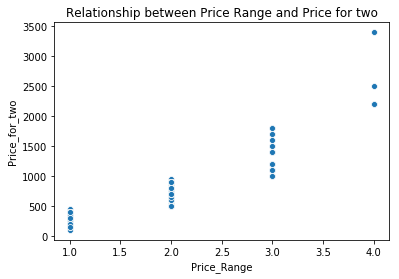

In [204]:
sns.scatterplot(x=zomato_venues1['Price_Range'],y=zomato_venues1['Price_for_two'])
plt.title('Relationship between Price Range and Price for two');

From the above plot we can come to the conclusion that:  
`Price Range (1)` : Less than 500 Rs  
`Price Range (2)` : 500 - 1000 Rs  
`Price Range (3)` : 1000 - 2000 Rs  
`Price Range (4)` : Above 2000 Rs

In [205]:
zomato_venues1.dtypes

Venue              object
Latitude          float64
Longitude         float64
Price_for_two     float64
Price_Range       float64
Rating            float64
Address            object
Neighbourhood      object
Venue Category     object
dtype: object

In [206]:
zomato_venues1['Rating'] = pd.to_numeric(zomato_venues1['Rating'],downcast='float')

### 2) Is there any relationship between Price and Rating 

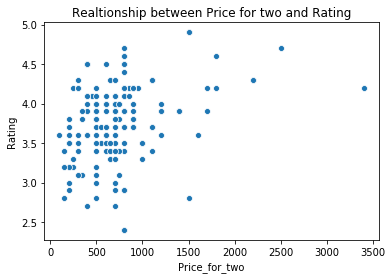

In [207]:
sns.scatterplot(x=zomato_venues1['Price_for_two'],y=zomato_venues1['Rating'])
plt.title('Realtionship between Price for two and Rating');

In [208]:
zomato_venues1.corr()

,Latitude,Longitude,Price_for_two,Price_Range,Rating
Latitude,1.000000,-0.444583,0.027238,0.055235,-0.242493
Longitude,-0.444583,1.000000,-0.086915,-0.104920,0.032944
Price_for_two,0.027238,-0.086915,1.000000,0.890703,0.324632
Price_Range,0.055235,-0.104920,0.890703,1.000000,0.239700
Rating,-0.242493,0.032944,0.324632,0.239700,1.000000


We obsereve that there is no relationship between the Price and the Rating.  
  
  What we can obsereve from here is that majority of the venues price fall under the Price Range (2) i.e. from 500 - 1000 Rs and most of their rating are above 3.

In [209]:
len(zomato_venues1['Neighbourhood'].unique())

16

In [210]:
neigh = zomato_venues1.groupby('Neighbourhood').mean()

In [211]:
neigh.head()

,Latitude,Longitude,Price_for_two,Price_Range,Rating
Neighbourhood,,,,,
"Bahadurpura, Kishanbagh, Tadbun",17.448501,78.467273,612.500000,2.000000,3.900000
Banjara Hills,17.409287,78.431540,805.000000,1.900000,4.080000
"Bazarghat (Hyderabad), A.Gs Office, Vidhan Sabha (Hyderabad), Anandnagar (Hyderabad), Khairatabad H.O, Parishram Bhawan",17.404812,78.460471,761.538462,1.980769,3.901923
"Bolarum, Alwal, Bolarum Bazar",17.420218,78.454857,783.333333,2.000000,3.800000
Hakimpet,17.457886,78.396722,655.555556,1.888889,3.400000


###  Which neighbourhood has the higherst average price ?

We want to find if the hotels in a particular neighborhood have average price greater than other neighborhoods. 

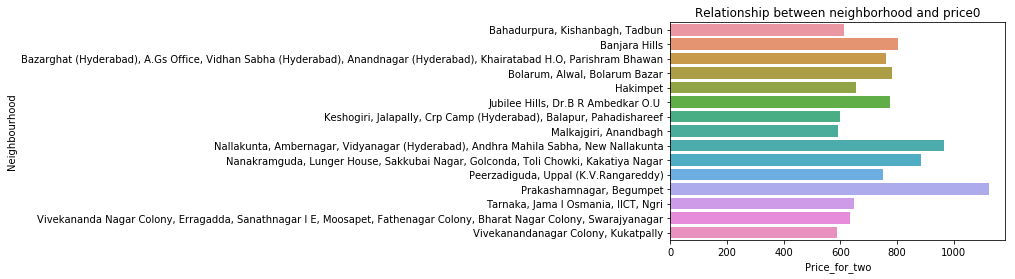

In [212]:
sns.barplot(y=neigh.index,x=neigh['Price_for_two'])
plt.title('Relationship between neighborhood and price0');

Most of the neighborhoods have their price for two below 800 .While neighborhood of Begumpet, Prakashamnagar have the highest average price for two of 1300 Rs. Followed by that venues in Nallakunta have average price for two people is 1000 Rs.

### Which neighborhoods have highest average rating?


We want to find which neighborhood has the highest average rating compared to other neighborhoods.

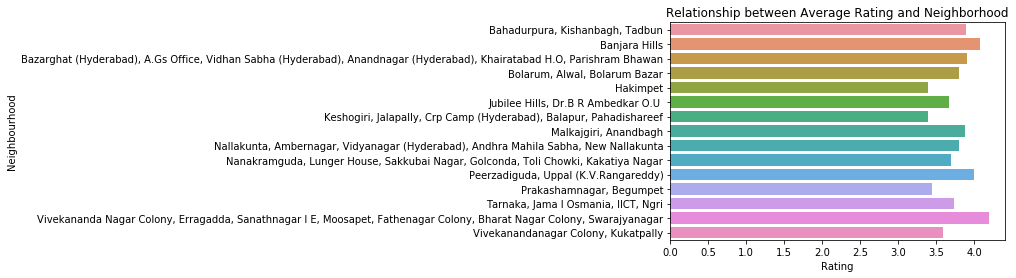

In [213]:
sns.barplot(y=neigh.index,x=neigh['Rating'])
plt.title('Relationship between Average Rating and Neighborhood');

We can obsereve that most of the neighborhoods have an average rating of 3.5. While Bahadurpura, Kishanbagh has the highest average rating of 4.25.  
While neighborhoods of Nallakunta,Malkajgiri and Balapur have average rating of 4.

### Which venue category has highest average price in the city

By finding this we can find out which venue category on average has highest price for two. 

In [214]:
venue_category_count=zomato_venues1.groupby('Venue Category').mean()

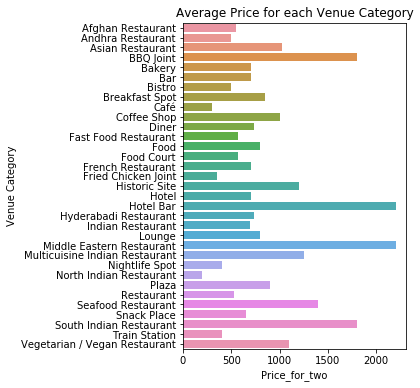

In [215]:
plt.figure(figsize=(4,6))
sns.barplot(y=venue_category_count.index,x=venue_category_count['Price_for_two']);
plt.title('Average Price for each Venue Category');

From the above plot we can understand that Venue Categories **Hotel bar** and **Middle Eastern Restaurant** has the highest average price for two of more than 2000 Rs per two people.

In [216]:
zomato_venues1.head()

,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category
0,Cafe Bahar,17.399741,78.478595,400.0,1.0,4.5,"3-5/815A, Hyderguda, Basheer Bagh, Hyderabad","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant
1,Hotel Shadab,17.368801,78.475533,900.0,2.0,4.2,"Plot 21, Opposite Madina Circle, High Court Ro...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Diner
2,Santosh Dhaba Exclusive,17.388353,78.479571,500.0,2.0,4.2,"8-2-629/1/2, Hanuman Tekdi, Near Hotel Jaya In...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant
3,Sarvi Restaurant,17.412893,78.449672,850.0,2.0,4.2,"6-2-626, Opposite Care Hospital, Road 1 & 11, ...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant
4,Paradise Biryani,17.412368,78.465337,950.0,2.0,4.2,"NTR Gardens, Near Prasads IMAX, Saifabad, Neck...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant


In [285]:
zomato_venues1.shape

(158, 10)

In [286]:
zomato_venues['Rating'].mean()

3.6141104294478517

In [296]:
zomato_venues1[zomato_venues1['Price_for_two']==3400]

,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category,Cluster Labels
9,Kebabs & Kurries - ITC Kakatiya,17.432417,78.456323,3400.0,4.0,4.2,"ITC Kakatiya, 6 3 1187, Begumpet, Hyderabad","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,2


## Clustering

In this section we will cluster the dataset based on price_for_two, price range, rating , venue category.
We will perform One Hot Encoding to convert the categorical values into numeric.

In [243]:
venues_onehot = pd.get_dummies(zomato_venues1[['Price_Range']], prefix="", prefix_sep="")
venues_onehot.head()

,1.0,2.0,3.0,4.0
0,1,0,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [244]:
venues_onehot['Venue']=zomato_venues1['Venue']

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]
venues_onehot.head()


,Venue,1.0,2.0,3.0,4.0
0,Cafe Bahar,1,0,0,0
1,Hotel Shadab,0,1,0,0
2,Santosh Dhaba Exclusive,0,1,0,0
3,Sarvi Restaurant,0,1,0,0
4,Paradise Biryani,0,1,0,0


In [245]:
venues_onehot.shape

(158, 5)

In [246]:
venues_onehot['Price_for_two']=zomato_venues1['Price_for_two']

In [247]:
venues_onehot['Rating']=zomato_venues1['Rating']
venues_onehot.head()

,Venue,1.0,2.0,3.0,4.0,Price_for_two,Rating
0,Cafe Bahar,1,0,0,0,400.0,4.5
1,Hotel Shadab,0,1,0,0,900.0,4.2
2,Santosh Dhaba Exclusive,0,1,0,0,500.0,4.2
3,Sarvi Restaurant,0,1,0,0,850.0,4.2
4,Paradise Biryani,0,1,0,0,950.0,4.2


In [248]:
fixed_columns = [venues_onehot.columns[0]] +list(venues_onehot.columns[-2:])+ list(venues_onehot.columns[1:-2])
venues_onehot = venues_onehot[fixed_columns]
venues_onehot.head()


,Venue,Price_for_two,Rating,1.0,2.0,3.0,4.0
0,Cafe Bahar,400.0,4.5,1,0,0,0
1,Hotel Shadab,900.0,4.2,0,1,0,0
2,Santosh Dhaba Exclusive,500.0,4.2,0,1,0,0
3,Sarvi Restaurant,850.0,4.2,0,1,0,0
4,Paradise Biryani,950.0,4.2,0,1,0,0


Before clustering the above data we have to find out the optimum K value.  
  
  To do that we use `Elbow Method`.

### Elbow Method

In [249]:
k_means = venues_onehot.iloc[:,1:]
k_means.head()

,Price_for_two,Rating,1.0,2.0,3.0,4.0
0,400.0,4.5,1,0,0,0
1,900.0,4.2,0,1,0,0
2,500.0,4.2,0,1,0,0
3,850.0,4.2,0,1,0,0
4,950.0,4.2,0,1,0,0


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


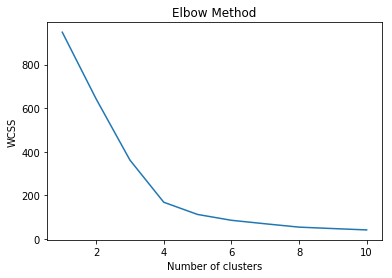

In [257]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
K_dataSet=StandardScaler().fit_transform(k_means)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(K_dataSet)
    wcss.append(kmeans.inertia_)
    
#plotting the cost function
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show();


## K Means Clustering 

In [251]:
kclusters = 4

K_dataSet=StandardScaler().fit_transform(k_means)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(K_dataSet)

zomato_venues1['Cluster Labels'] = kmeans.labels_

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [284]:
map_clusters = folium.Map(location=[17.38878595, 78.46106473453146], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, pot, r in zip(zomato_venues1['Latitude'], zomato_venues1['Longitude'], zomato_venues1['Venue'], zomato_venues1['Cluster Labels'],zomato_venues1['Price_for_two'],zomato_venues['Rating']):
    label = folium.Popup(str(poi) + '\nPrice_for_two: ' + str(pot) + '\nRating' + str(r), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0

In [264]:
cluster0 = zomato_venues1[zomato_venues1['Cluster Labels'] == 0]
print("Cluster 0")
cluster0.head(5).reset_index(drop = True)

Cluster 0


,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category,Cluster Labels
0,Hotel Shadab,17.368801,78.475533,900.0,2.0,4.2,"Plot 21, Opposite Madina Circle, High Court Ro...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Diner,0
1,Santosh Dhaba Exclusive,17.388353,78.479571,500.0,2.0,4.2,"8-2-629/1/2, Hanuman Tekdi, Near Hotel Jaya In...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,0
2,Sarvi Restaurant,17.412893,78.449672,850.0,2.0,4.2,"6-2-626, Opposite Care Hospital, Road 1 & 11, ...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,0
3,Paradise Biryani,17.412368,78.465337,950.0,2.0,4.2,"NTR Gardens, Near Prasads IMAX, Saifabad, Neck...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,0
4,Shah Ghouse Cafe & Restaurant,17.396299,78.424931,700.0,2.0,4.1,"House 9-4-86/17, Salarjung Colony, Circle 10, ...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,0


In [282]:
print("Venues for Cluster 0 have Average Price of {:.02f} and Rating around {:.02f} and Price Range {:0.2f}".
      format(cluster0['Price_for_two'].mean(), cluster0['Rating'].mean(),cluster0['Price_Range'].astype('float').mean()))

Venues for Cluster 0 have Average Price of 695.74 and Rating around 3.77 and Price Range 2.00


In [266]:
cluster1 = zomato_venues1[zomato_venues1['Cluster Labels'] == 1 ]
print("Cluster 1")
cluster1.head(5).reset_index(drop = True)

Cluster 1


,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category,Cluster Labels
0,Blue Fox,17.401313,78.485752,1200.0,3.0,3.9,"3-6-199/1, Himayath Nagar, Hyderabad","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,1
1,Ohri's Serengeti,17.408402,78.438880,1500.0,3.0,4.9,"8-2-682/3, 5th Floor, Ohri's Banjara, Road 12,...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,1
2,Angeethi Asli Dhaba,17.415245,78.448879,1100.0,3.0,3.7,"5th Floor, City Center Mall, Road 1, Banjara H...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,1
3,Tulips - Hotel GreenPark,17.435937,78.453873,1400.0,3.0,3.9,"Hotel Green Park, Begumpet, Hyderabad","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Food Court,1
4,Blue Fox,17.401313,78.485752,1200.0,3.0,3.9,"3-6-199/1, Himayath Nagar, Hyderabad","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,1


In [281]:
print("Venues for Cluster 1 have Average Price of {:.02f} and Rating around {:.02f} and Price Range {:0.2f}".
      format(cluster1['Price_for_two'].mean(), cluster1['Rating'].mean(),cluster1['Price_Range'].astype('float').mean()))

Venues for Cluster 1 have Average Price of 1330.43 and Rating around 3.91 and Price Range 3.00


### Cluster 2

In [267]:
cluster2 = zomato_venues1[zomato_venues1['Cluster Labels'] == 2]
print("Cluster 2")
cluster2.head(5).reset_index(drop = True)

Cluster 2


,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category,Cluster Labels
0,Kebabs & Kurries - ITC Kakatiya,17.432417,78.456323,3400.0,4.0,4.2,"ITC Kakatiya, 6 3 1187, Begumpet, Hyderabad","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,2
1,Jewel of Nizam - The Golkonda Hotel,17.404361,78.454107,2200.0,4.0,4.3,"The Golkonda Hotel, 10-1-124, Banjara Hills, M...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Middle Eastern Restaurant,2
2,Jewel of Nizam - The Golkonda Hotel,17.404361,78.454107,2200.0,4.0,4.3,"The Golkonda Hotel, 10-1-124, Banjara Hills, M...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Hotel Bar,2
3,Jewel of Nizam - The Minar - The Golkonda Resort,17.389428,78.315144,2500.0,4.0,4.7,"The Minar Golkonda Resorts, Gandipet, Hyderabad","Nanakramguda, Lunger House, Sakkubai Nagar, Go...",Asian Restaurant,2


In [280]:
print("Venues for Cluster 2 have Average Price of {:.02f} and Rating around {:.02f} and Price Range {:0.2f}".
      format(cluster2['Price_for_two'].mean(), cluster2['Rating'].mean(),cluster2['Price_Range'].astype('float').mean()))

Venues for Cluster 2 have Average Price of 2575.00 and Rating around 4.38 and Price Range 4.00


### Cluster 3

In [268]:
cluster3 = zomato_venues1[zomato_venues1['Cluster Labels'] == 3]
print("Cluster 3")
cluster3.head(5).reset_index(drop = True)

Cluster 3


,Venue,Latitude,Longitude,Price_for_two,Price_Range,Rating,Address,Neighbourhood,Venue Category,Cluster Labels
0,Cafe Bahar,17.399741,78.478595,400.0,1.0,4.5,"3-5/815A, Hyderguda, Basheer Bagh, Hyderabad","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,3
1,Mohini Multicuisine Restaurant,17.401860,78.476094,400.0,1.0,3.9,"3-6/342, Opposite Babukhan Estate, Basheer Bag...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,3
2,Chinese Fast Food,17.406472,78.497762,200.0,1.0,2.9,"RTC Cross Roads, Opposite Bawarchi, Nallakunta...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,3
3,Season The Restaurant,17.388091,78.477744,200.0,1.0,3.5,"Hotel Mandakini, Jaya International, Hanuman T...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,3
4,Khan Saheb,17.405688,78.451785,350.0,1.0,3.1,"10-5-2-7/A, Banjara Hills Road 1, Masab Tank, ...","Bazarghat (Hyderabad), A.Gs Office, Vidhan Sab...",Indian Restaurant,3


In [279]:
print("Venues for Cluster 3 have Average Price of {:.02f} and Rating around {:.02f} and Price Range {:0.2f}".
      format(cluster3['Price_for_two'].mean(), cluster3['Rating'].mean(),cluster3['Price_Range'].astype('float').mean()))

Venues for Cluster 3 have Average Price of 289.19 and Rating around 3.64 and Price Range 1.00


<a id='result'></a>
## Result and Description

We have performed a number of analysis on the Biryani Venues in Hyderabad. This project will be definitely helpful to anyone who is visiting Hyderabad.  

  We have collected the neighborhoods of Hyderabad from a website and using those neighborhoods pincode we were able to find the latitude and longitudes of those neighborhoods using PGeocode Library.  
  
  We used the help of Foursqaure API to get the various biryani venues in that neighborhood. We even got the venue details using Foursqaure API but since most of the data is missing value, we used the help of Zomato API.  
  There are a total of 158 venues in our dataset. From what we have obsereved 
  
  1) Majority of the venues have their price below 1000 Rs. This is a very reasonble cost and any Indian middle class people can afford to eat it. Further not is the price less for majority of the venues, most of restaurant have an average rating of 3.5 which is very decent for the price.  
  
  2) In any given location there are hotels with most of the clusters which gives the visitor more options to choose from his budget.  
  
  3) Neighborhoods towards the east and south of city has venues which provide biryani for a much cheaper price, while area towards the northa and west have all kinds of price ranges.  
  
  4) The venues are spread pretty much everywhere in the city so it shouldn't be a problem for the visitor.
 
  5) Dwaraka tiffins provides cheapest biryani for just 100 Rs for two people and it has a rating of 3.6.  
  
  6) Kebabs & Kurries - ITC Kakatiya provides that costliest biryani at 3400 for two people with a rating of 4.2.  
  
  7) Venues in Begumpet and Prakashamnagar neighgorhood are costliest whicle kukatpally has lowest biryani prices.  
  


<a id='conclusion'></a>
## Conclusion

This project provides in detail information regarding the price and ratings of various venues ranging from the cheapest venue to the costliest venue, which gives the visitor a wide range of option to choose from. It makes the work easier for business people who don't have much time to explore the city, to choose a venue which helps them experience the Hyderabadi Biryani.